# Recreate the GAMA cross correlation using `meer21cm`

This notebook aims at recreating the `meerpower` pipeline for the results used in cross-correlation between L-band deep-field data and GAMA galaxy. Through building this, people who used `meerpower` should be able to migrate to `meer21cm` relatively easily. 

This notebook is largely unfinished and in early stages. Due to adhering to PEP8 and other design philosophy reasons, many functionalities are not going to be identical copies. The goal right now is to recreate every figure in almost identical manner. But hopefully this is still straightforward enough to adapt to.

In [1]:
from astropy.cosmology import Planck18
import matplotlib.pyplot as plt
import numpy as np
from meer21cm.cosmology import CosmologyCalculator
from meer21cm.io import filter_incomplete_los, read_map, cal_freq
from astropy.wcs import WCS
from meer21cm.plot import *
from meer21cm.telescope import dish_beam_sigma, gaussian_beam, isotropic_beam_profile, weighted_convolution
from meer21cm.util import pcaclean, freq_to_redshift, redshift_to_freq
from hiimtool.basic_util import centre_to_edges
from astropy.io import fits
from astropy.wcs.utils import proj_plane_pixel_area
from meer21cm.grid import *
from scipy import signal
from meer21cm.power import *
from meer21cm import Specification, PowerSpectrum

[Zhaotingdebijibendiannao.local:79094] shmem: mmap: an error occurred while determining whether or not /var/folders/g4/7xh65ljx6l17g9wztg7t6c2w0000gn/T//ompi.Zhaotingdebijibendiannao.501/jf.0/1191247872/sm_segment.Zhaotingdebijibendiannao.501.47010000.0 could be created.


The readin function has been rewritten. Counts file need to be passed explicitly. The goal is to avoid writing things to specific datasets that will be invalid later.

`nu` is in Hz now and the map is either in Kelvin of Jansky. It is better that we stick to consistent units throughout and use SI units whenever reasonable and then common units (Mpc, Jy etc) if needed. If one functionality uses non-standard unit, the unit of the input should be an explicit argument.

The `read_map` function does not return `w_HI`. It was simply set to uniform in the original function which is confusing.

In [2]:
cosmo = Planck18
file_dir = '/Users/zhaotingchen/Desktop/work/sd_stacking/draft/'
fits_file = file_dir+'Nscan961_Tsky_cube_p0.3d_sigma4.0_iter2.fits'
counts_file = file_dir+'Nscan961_Npix_count_cube_p0.3d_sigma4.0_iter2.fits'
gal_file = file_dir+'../G23TilingCatv11.fits'

numin=971*1e6
numax=1023.8*1e6
ps = PowerSpectrum(
    map_file=fits_file,
    counts_file=counts_file,
    nu_min=numin,
    nu_max=numax,
    cosmo=cosmo,
    gal_file=gal_file,
)
# read in map_file
ps.read_from_fits()
# read in galaxy file
ps.read_gal_cat()

no input beam found, setting include_beam to False
no input beam found, setting include_beam to False


In [3]:
def OmegaHImodel(z):
     # Matches SKAO red book and Alkistis early papers also consistent with GBT
     #   Masui + Wolz measurements at z=0.8
    return 0.00048 + 0.00039*z - 0.000065*z**2


The plot utility is largely kept the same

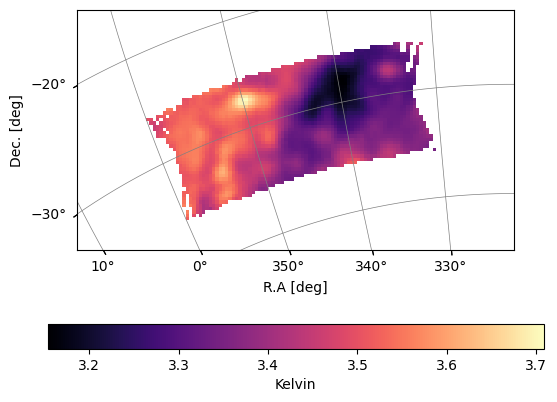

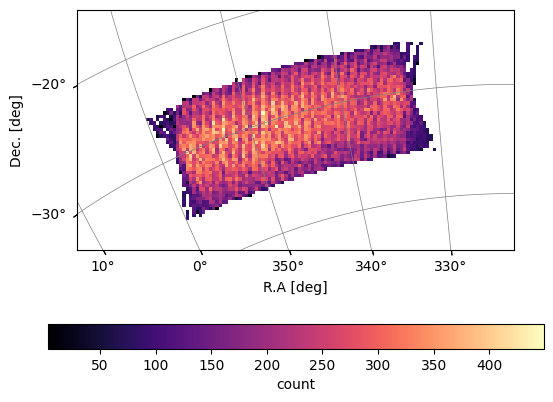

In [4]:
plot_map(ps.data,ps.wproj,W=ps.W_HI,cbar_label='Kelvin')
plot_map(ps.w_HI,ps.wproj,W=ps.W_HI,cbar_label='count')

We can trim the map by specifying the range of RA and Dec.

The reconvolution function is decomposed and rewritten. Now, there are a few modulised steps to do this. This is so that when we want to change the beam function (e.g. sinc instead of gaussian) or do other things, the code should be able to handle that.

First, we retrieve the Gaussian beam size just like before, now using `dish_beam_sigma`.

In [5]:
D_dish = 13.5 # Dish-diameter [metres]
gamma = 1.4 # resmoothing factor - set = None to have no resmoothing
sigma_ch = dish_beam_sigma(D_dish,ps.nu,)
sigma_max = sigma_ch.max()

Deconvolution and then reconvolution in Fourier space is just divide the beam kernel and then multiply the new beam kernel. Therefore in real space the denominator of the exponential subtracts each other: 

In [6]:
reconvolve_sigma = np.sqrt(gamma*sigma_max**2 - sigma_ch**2)

In [7]:
sigma_beam_ch = np.ones_like(ps.nu)*np.sqrt(gamma)*sigma_max
ps.sigma_beam_ch = sigma_beam_ch

Then, an image of the beam on the fits grids is made. Note that a different function and a sigma would also work as long as the beam does not have directionality using `isotropic_beam_profile`

In [8]:
beam_cube = np.zeros_like(ps.data)
for i in range(len(ps.nu)):
    beam_func = gaussian_beam(reconvolve_sigma[i])
    beam_cube[:,:,i] = isotropic_beam_profile(ps.num_pix_x,ps.num_pix_y,ps.wproj,beam_func)

Finally, a weighted convolution can be performed with the beam cube

In [9]:
MKmap,w_HI = weighted_convolution(ps.data,beam_cube,ps.w_HI)
# remove artefacts outside the range
MKmap *= ps.W_HI
w_HI *= ps.W_HI

ps.data = MKmap
ps.w_HI = w_HI

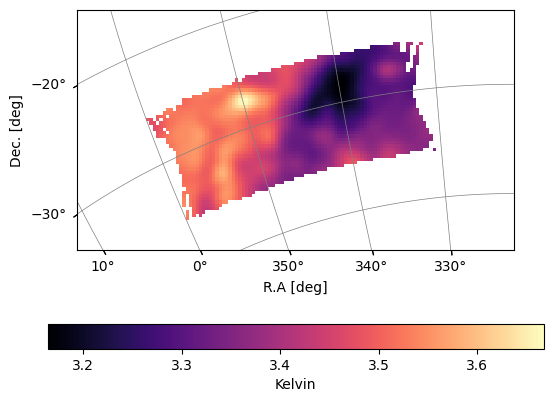

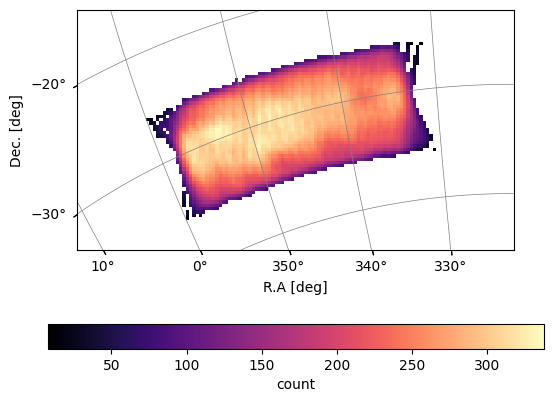

In [10]:
plot_map(ps.data,ps.wproj,W=ps.W_HI,cbar_label='Kelvin')
plot_map(ps.w_HI,ps.wproj,W=ps.W_HI,cbar_label='count')

We want to trim the edges:

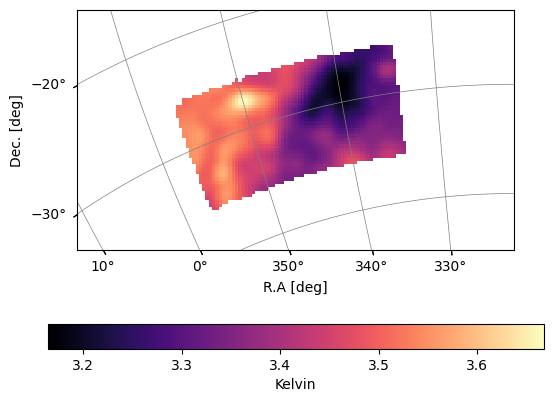

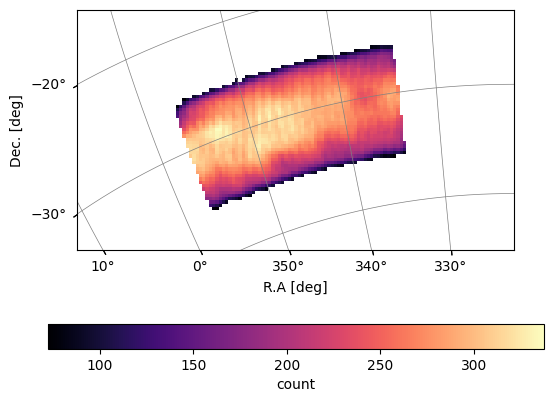

In [11]:
raminMK,ramaxMK = 334,357
ps.ra_range = [raminMK,ramaxMK]
# read data again to update
ps.trim_map_to_range()

plot_map(ps.data,ps.wproj,W=ps.W_HI,cbar_label='Kelvin')
plot_map(ps.w_HI,ps.wproj,W=ps.W_HI,cbar_label='count')

Examining the los spectrum is now `plot_pixels_along_los`

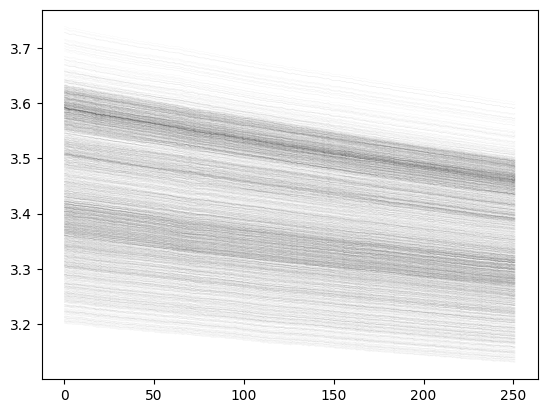

In [12]:
plot_pixels_along_los(ps.data,ps.W_HI)

PCA cleaning is rewritten to tidy up the code but also to address several inconsistencies:

- The calculation of covariance is not renormalised if we simply do `np.cov(weight*map)`.
- Calculation of the mean of the data vector should be consistent with the covariance. That is, if weights are used in covariance, it should also be used in calculating the mean
- Only one weight should be used at a time. So if a binary mask is used, then the counts are not used, vice versa.

In my test, actually non-weighted PCA works better it seems:

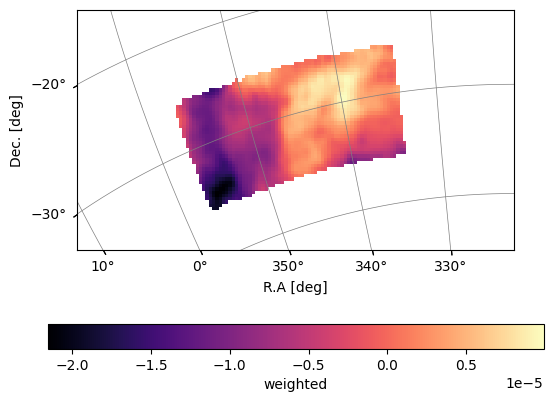

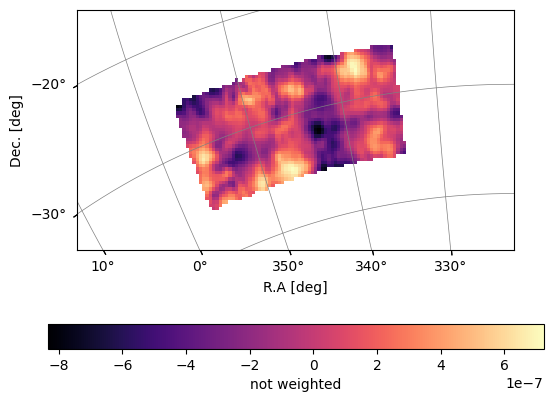

In [13]:
N_fg = 10
MKmap_clean = pcaclean(ps.data,N_fg,weights=ps.w_HI,mean_centre=True)
plot_map(MKmap_clean,ps.wproj,W=ps.W_HI,cbar_label='weighted')

N_fg = 10
MKmap_clean = pcaclean(ps.data,N_fg,weights=ps.W_HI,mean_centre=True)
plot_map(MKmap_clean,ps.wproj,W=ps.W_HI,cbar_label='not weighted')

Plan: To keep it flexible

In [14]:
cov_map,eignumb,eigenval,V = pcaclean(ps.data,N_fg=1,weights=ps.W_HI,return_analysis=True,mean_centre=True) # weights included in covariance calculation


In [15]:
nu_edges = centre_to_edges(ps.nu)

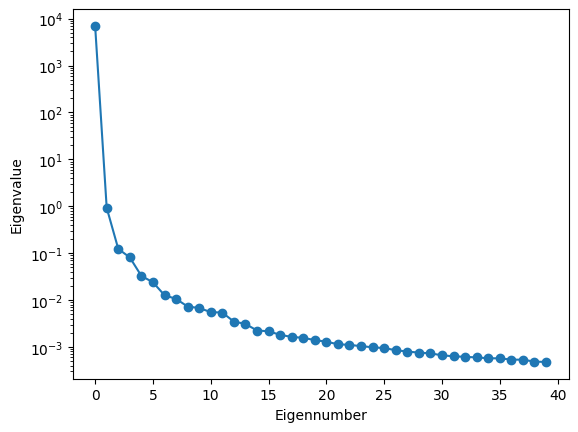

<Figure size 640x480 with 0 Axes>

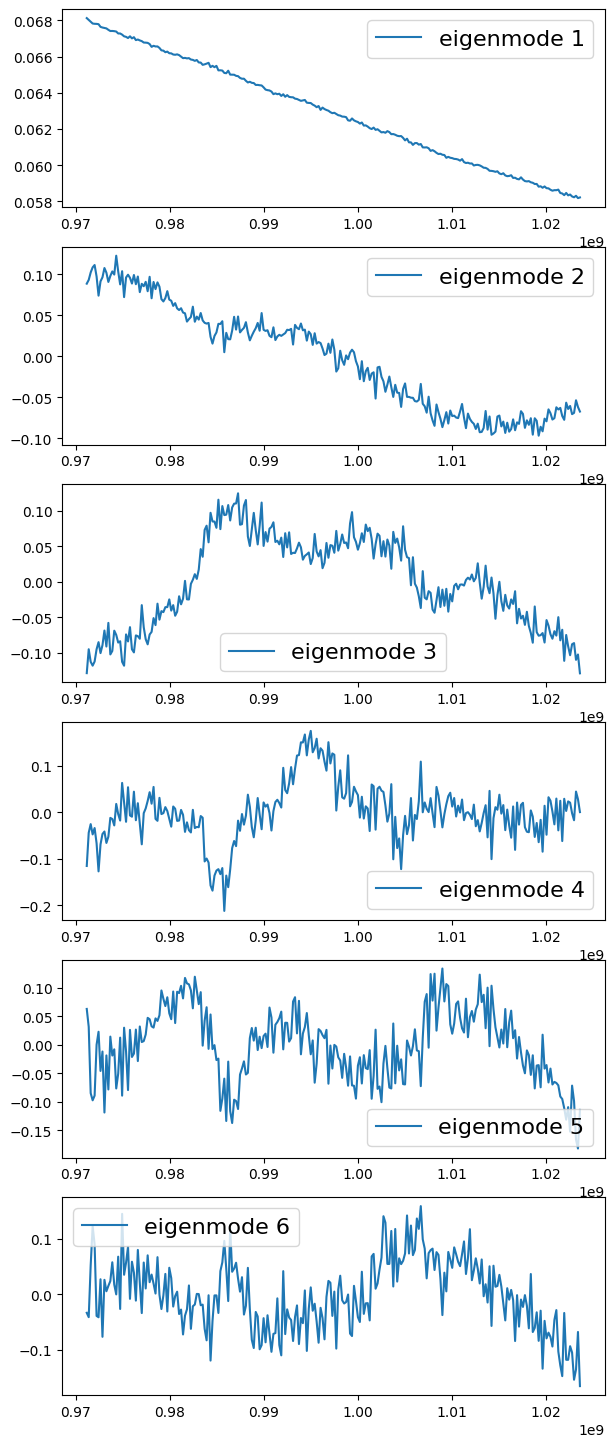

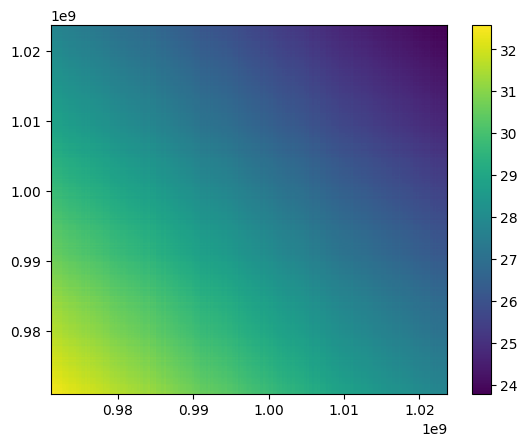

In [16]:
plot_eigenspectrum(np.array([eigenval]))
plt.figure()
Num = 6
chart = 100*Num + 11
plt.figure(figsize=(7,3*Num))
for i in range(Num):
    plt.subplot(chart + i)
    plt.plot(ps.nu,V[:,i],label='eigenmode %s'%(i+1))
    #plt.plot(nu,V[:,i],label='eigenmode %s'%(i+1))
    plt.legend(fontsize=16)
plt.figure()
plt.pcolormesh(nu_edges,nu_edges,cov_map)
plt.colorbar()
plt.show()

In [17]:
ps.data = MKmap_clean

Now let's look at the galaxy catalogue:

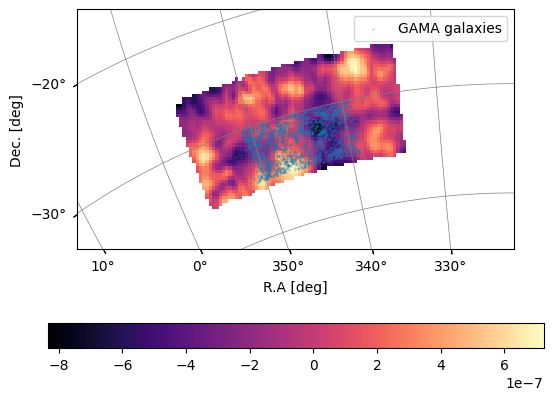

In [18]:
plot_map(ps.data,ps.wproj,W=ps.W_HI)
ax = plt.gca()
plt.scatter(ps.ra_gal,ps.dec_gal,transform=ax.get_transform('world'),
            s=1,label='GAMA galaxies',color='tab:blue',
            alpha=0.2
           )
plt.legend()

We now only want to focus on the cross-correlation. So let's trim off stuff outside the GAMA galaxy range and also some of its edges:

In [19]:
raminGAMA,ramaxGAMA = 339,351
decminGAMA,decmaxGAMA = -35,-30

ps.ra_range = (raminGAMA,ramaxGAMA)
ps.dec_range = (decminGAMA,decmaxGAMA)

ps.trim_gal_to_range()
ps.trim_map_to_range()

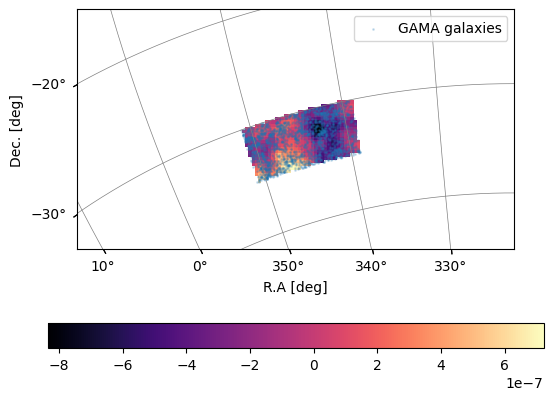

In [20]:
plot_map(ps.data,ps.wproj,W=ps.W_HI)
ax = plt.gca()
plt.scatter(ps.ra_gal,ps.dec_gal,transform=ax.get_transform('world'),
            s=1,label='GAMA galaxies',color='tab:blue',
            alpha=0.2
           )
plt.legend()

gridding:

First, let us retrieve the box dimensions:

Here I deviated a bit from `meerpower`, because I have some code previously to calculate the dimensions etc. They are well tested (see `tests/test_grid.py`) so I decide that is easier. Essentially it does the same thing, just finding the box length and the origin of the box.

Let us first decide that, comparing to the original map pixel, how much we want to downscale the resolution in the regular grid (usually downscaling is needed to avoid large gridding effects)

In [82]:
# specify some scaling factor
ps.downscale_factor_transverse = 2.0 # increase for lower resolution FFT Cartesian grid
ps.downscale_factor_radial = 2.0
ps.box_buffkick = 10
#    **sp.__dict__,
#)

In [83]:
ps.get_enclosing_box()
hi_map_rg,hi_weights_rg,pixel_counts_hi_rg =  ps.grid_data_to_field()
gal_map_rg,gal_weights_rg,pixel_counts_gal_rg =  ps.grid_gal_to_field()


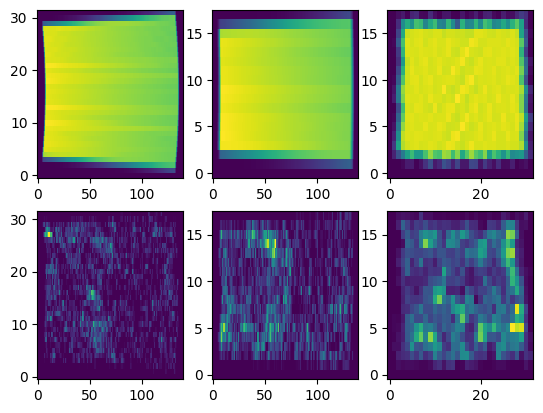

In [84]:
### Gridding sanity-check
fig, axes = plt.subplots(2,3)
for i in range(3):
    axes[0,i].imshow(
        pixel_counts_hi_rg.mean(axis=i),interpolation='none',
        aspect='auto',
        origin='lower',
    )
    axes[1,i].imshow(
        pixel_counts_gal_rg.mean(axis=i),interpolation='none',
        aspect='auto',
        origin='lower',
    )

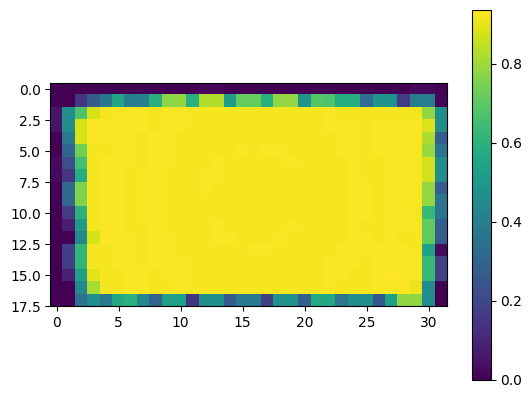

In [85]:
plt.imshow((pixel_counts_hi_rg>0).mean(axis=-1))
plt.colorbar()

In [86]:
nkbin = 16
# in h/Mpc
kmin,kmax = 0.07,0.3
kbins = np.linspace(kmin,kmax,nkbin+1) # k-bin edges [using linear binning]
# in Mpc-1
kbins *= cosmo.h
# in h/Mpc
kcuts = [0.052,0.031,0.175,np.inf] #[kperpmin,kparamin,kperpmax,kparamax] (exclude areas of k-space from spherical average)
# in Mpc-1
kcuts = np.array(kcuts)*cosmo.h

ps.k1dbins = kbins

k_mode = ps.kmode
mu_mode = ps.mumode
k_para = ps.k_mode*mu_mode
k_perp = np.sqrt(1-mu_mode**2)*k_mode
k_sel = ((k_perp>kcuts[0])*(np.abs(k_para)>kcuts[1])*(k_perp<kcuts[2])*(np.abs(k_para)<kcuts[3]))


The gridded field data has been automatically stored as `ps.field_1` and `ps.field_2`.
The choice of the weights for calculating the power spectrum is a bit arbitrary. What you typically want is to make sure you give zero weights to poorly sampled regions. It is also useful to apply frequency tapers. That is because you typically deal with a lightcone shape 

In [87]:

tukey_alpha = 0.8
tukey = signal.windows.tukey(ps.box_ndim[-1], alpha=tukey_alpha)
taper_HI = tukey
taper_g = tukey
ps.weights_1 = (
    ((pixel_counts_hi_rg>0).mean(axis=2)>0.51)[:,:,None]
)*taper_HI[None,None,:]
ps.weights_2 = (
    ((pixel_counts_hi_rg>0).mean(axis=2)>0.51)[:,:,None]
)*taper_HI[None,None,:]

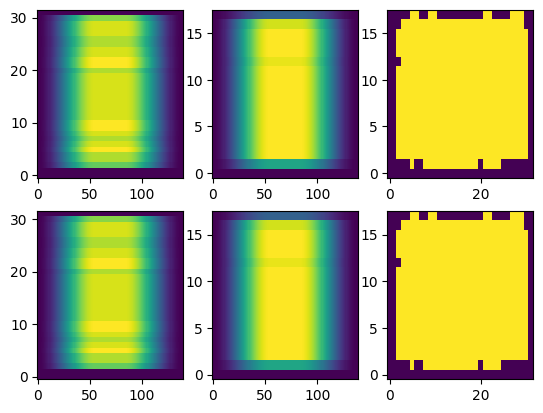

In [88]:
### Gridding sanity-check
fig, axes = plt.subplots(2,3)
for i in range(3):
    axes[0,i].imshow(
        ps.weights_1.mean(axis=i),interpolation='none',
        aspect='auto',
        origin='lower',
    )
    axes[1,i].imshow(
        ps.weights_2.mean(axis=i),interpolation='none',
        aspect='auto',
        origin='lower',
    )

We are also interested in comparing the measurements with some model. The model ps can be automatically computed within `ps` with all the beam and sampling effects included, with RSD applied and current $k$-modes matching the measurements. Just tell `ps` your model parameters:

In [89]:
b_HI = 1.5
OmegaHIbHI = 0.85e-3 # MKxWiggleZ constraint
OmegaHI = OmegaHIbHI/b_HI
r_cross = 0.9 # cross-correlation coefficient
b_g = 1.9
#b_g = 1.5
sigma_v = 0.0

ps.tracer_bias_1 = b_HI
ps.omegahi = OmegaHI
ps.tracer_bias_2 = b_g
ps.cross_coeff = r_cross
ps.mean_amp_1 = 'average_hi_temp'

shot_noise_g = np.prod(ps.box_len)*(pixel_counts_hi_rg>0).mean()/ps.ra_gal.size

galaxy is gridded onto the regular grids which lead to the sampling at the regular grid box level:

In [90]:
ps.sampling_resol = ps.box_resol
shot_noise_g *= ps.step_sampling()
ps.sampling_resol = [ps.pix_resol_in_mpc,ps.pix_resol_in_mpc,ps.los_resol_in_mpc]

In [91]:
pmod_1d_gg,keff,_ = ps.get_1d_power(
    'auto_power_tracer_2_model'
)
psn_1d_gg,keff,_ = ps.get_1d_power(
    shot_noise_g,
)
pdata_1d_gg,keff,nmodes = ps.get_1d_power(
    'auto_power_3d_2',
)



pmod_1d_cross,keff_c,_ = ps.get_1d_power(
    'cross_power_tracer_model',
    k1dweights=k_sel,
)
pdata_1d_cross,keff_c,nmodes_c = ps.get_1d_power(
    'cross_power_3d',
    k1dweights=k_sel,
)

pmod_1d_hi,keff_hi,_ = ps.get_1d_power(
    'auto_power_tracer_1_model',
    k1dweights=k_sel,
)
pdata_1d_hi,keff_hi,nmodes_hi = ps.get_1d_power(
    'auto_power_3d_1',
    k1dweights=k_sel,
)


Using the number modes measured, we can also put in a naive error bar:

In [92]:
perror_1d_gg = (pdata_1d_gg)/np.sqrt(nmodes)
perror_1d_cross = np.sqrt((pdata_1d_cross)**2+pdata_1d_hi*pdata_1d_gg)/np.sqrt(nmodes_c)
perror_1d_hi = (pdata_1d_hi)/np.sqrt(nmodes_hi)


Text(0, 0.5, '$P_{\\rm gg}(k)\\,h^{-3}{\\rm Mpc}^3]$')

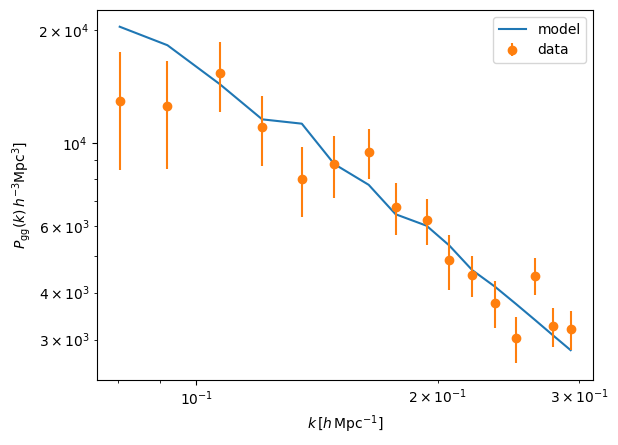

In [93]:
plt.plot(keff/cosmo.h,pmod_1d_gg*cosmo.h**3,label='model')
plt.errorbar(keff/cosmo.h,(pdata_1d_gg-psn_1d_gg)*cosmo.h**3,
             yerr=perror_1d_gg*cosmo.h**3,
             ls='none',
             marker='o',
             label='data')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm gg}(k)\,h^{-3}{\rm Mpc}^3]$')

Text(0, 0.5, '$k^2\\,P_{\\rm g,HI}(k)\\,[{\\rm mK}\\,h^{-1}{\\rm Mpc}]$')

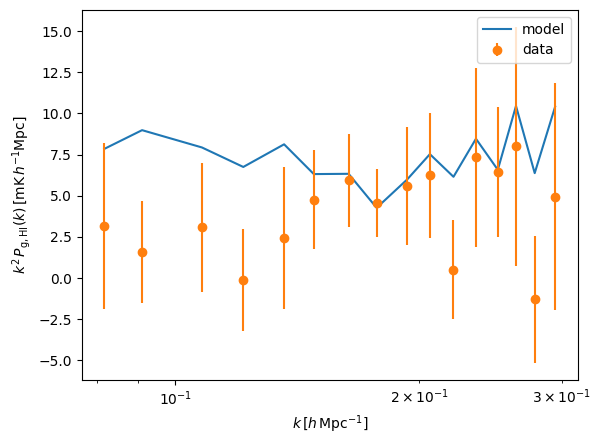

In [94]:
plt.plot(keff_c/cosmo.h,pmod_1d_cross*cosmo.h*keff_c**2*1e3,label='model')
plt.errorbar(keff_c/cosmo.h,pdata_1d_cross*cosmo.h*keff_c**2*1e3,
             yerr=perror_1d_cross*cosmo.h*keff_c**2*1e3,
             ls='none',
             marker='o',
             label='data')

plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$k^2\,P_{\rm g,HI}(k)\,[{\rm mK}\,h^{-1}{\rm Mpc}]$')